<a href="https://colab.research.google.com/github/Madhuanabala/breast-cancer/blob/model-building/clustering_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np

In [67]:
df=pd.read_excel("/content/data for clustering.xlsx")
df

,PHYTOCHEMICALNAME,anti-cancer,anti-inflammatory,anti-angiogenic,anti-metastatic
0,ursolic acid,1,0,1,1
1,quercitin,1,0,1,1
2,scopoletin,1,1,1,0
3,bergapten,1,0,0,0
4,"falcarindiol,",1,0,0,0
...,...,...,...,...,...
269,Santarubin C,1,1,0,0
270,Sinigrin,1,1,0,0
271,Acetylbarlerin,1,1,0,0
272,Alpha-Amyrin,1,1,1,1


In [73]:
from os import rename
df.columns = df.columns.str.strip()  # Remove leading/trailing spaces
df.rename(columns={'PHYTOCHEMICALNAME': 'Compounds Name'}, inplace=True)

In [74]:
print(df.head())  # Check if the column name has changed
print(df.columns)

   Compounds Name  anti-cancer  anti-inflammatory  anti-angiogenic  \
0    ursolic acid            1                  0                1   
1       quercitin            1                  0                1   
2      scopoletin            1                  1                1   
3       bergapten            1                  0                0   
4  falcarindiol,             1                  0                0   

   anti-metastatic  
0                1  
1                1  
2                0  
3                0  
4                0  
Index(['Compounds Name', 'anti-cancer', 'anti-inflammatory', 'anti-angiogenic',
       'anti-metastatic'],
      dtype='object')


In [76]:
# Feature selection
feature_columns = ["anti-cancer", "anti-inflammatory", "anti-angiogenic", "anti-metastatic"]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[feature_columns])

In [77]:
# Handle NaN or infinite values if present
if np.any(np.isnan(df[feature_columns])) or np.any(np.isinf(df[feature_columns])):
    df = df.dropna(subset=feature_columns)

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
df['Cluster'] = kmeans.fit_predict(df[feature_columns])

print("Number of compounds in each cluster:")
print(df['Cluster'].value_counts())

Number of compounds in each cluster:
Cluster
0    132
1     99
2     22
3     21
Name: count, dtype: int64


In [78]:
# Calculate cluster means
cluster_means = df.groupby('Cluster')[feature_columns].mean()
print("Mean Values for Each Cluster:")
print(cluster_means)

Mean Values for Each Cluster:
         anti-cancer  anti-inflammatory  anti-angiogenic  anti-metastatic
Cluster                                                                  
0                1.0           1.000000         0.946970         1.000000
1                1.0           0.818182         0.000000         0.000000
2                1.0           0.000000         0.909091         0.863636
3                1.0           1.000000         1.000000         0.000000


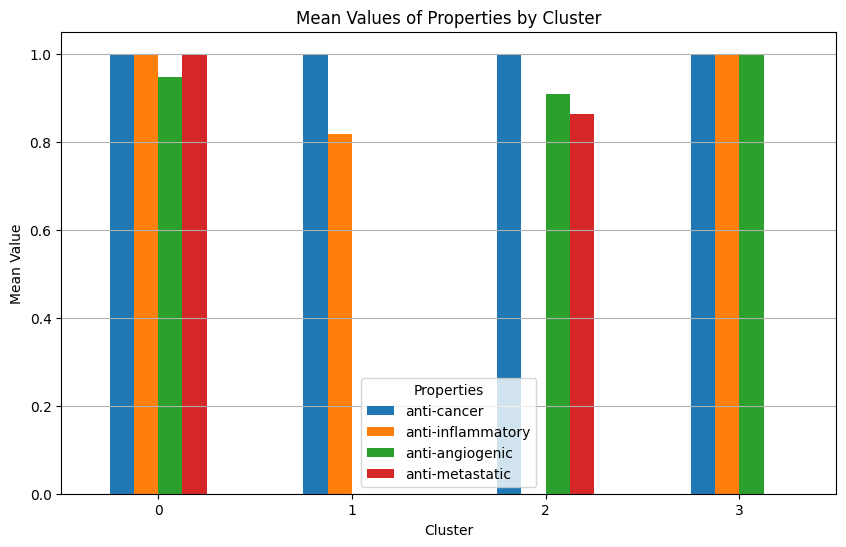

In [79]:
# Plot mean values of properties per cluster
ax = cluster_means.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Values of Properties by Cluster')
plt.ylabel('Mean Value')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title='Properties')
plt.show()

In [80]:
# Save cluster distribution
cluster_distribution = df['Cluster'].value_counts().reset_index()
cluster_distribution.columns = ['Cluster', 'Number of Compounds']
cluster_distribution.to_excel('Cluster_Distribution.xlsx', index=False)

In [81]:
# Save compound clustering results
grouped = df.groupby('Cluster')['Compounds Name'].apply(list).reset_index()
grouped.columns = ['Cluster', 'Compounds']
compounds_expanded = grouped['Compounds'].apply(pd.Series)
compounds_expanded.columns = [f'Compound {i+1}' for i in range(compounds_expanded.shape[1])]
final_output = pd.concat([grouped[['Cluster']], compounds_expanded], axis=1)
final_output.to_excel('Compounds_by_Cluster.xlsx', index=False)
print(final_output)


   Cluster    Compound 1      Compound 2            Compound 3  \
0        0     Berberine        Luteolin           gallic acid   
1        1     bergapten  falcarindiol,            quinic acid   
2        2  ursolic acid       quercitin  deoxypodophyllotoxin   
3        3    scopoletin       myricetin            kaempferol   

         Compound 4       Compound 5      Compound 6  \
0  Chlorogenic acid  Andrographolide       Diosgenin   
1            phytol         gossypin        Thiamine   
2       Vincristine      Girinimbine  Plumbagic acid   
3           fisetin         carnosol    Sulforaphane   

                 Compound 7         Compound 8   Compound 9  ... Compound 123  \
0               Astaxanthin           Honokiol  Schisandrin  ...  Oleocanthal   
1         Proanthocyanidins  D-Glucuronic Acid   Hyperoside  ...          NaN   
2                 Carvacrol         Hesperidin      Silybin  ...          NaN   
3  Epigallocatechin Gallate         Naringetol     Cyanidin  ...

In [82]:
# Compute Silhouette Score
silhouette_avg = silhouette_score(scaled_features, df['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

silhouette_df = pd.DataFrame({'Silhouette Score': [silhouette_avg]})
silhouette_df.to_excel('Clustering_Silhouette_Score.xlsx', index=False)

Silhouette Score: 0.798234873138006


The 0.79 and 0.82 are likely different due to the way the scores are computed: one being an overall score for the final clustering and the other possibly reflecting the highest score observed during the analysis (or different evaluations of the clustering process).

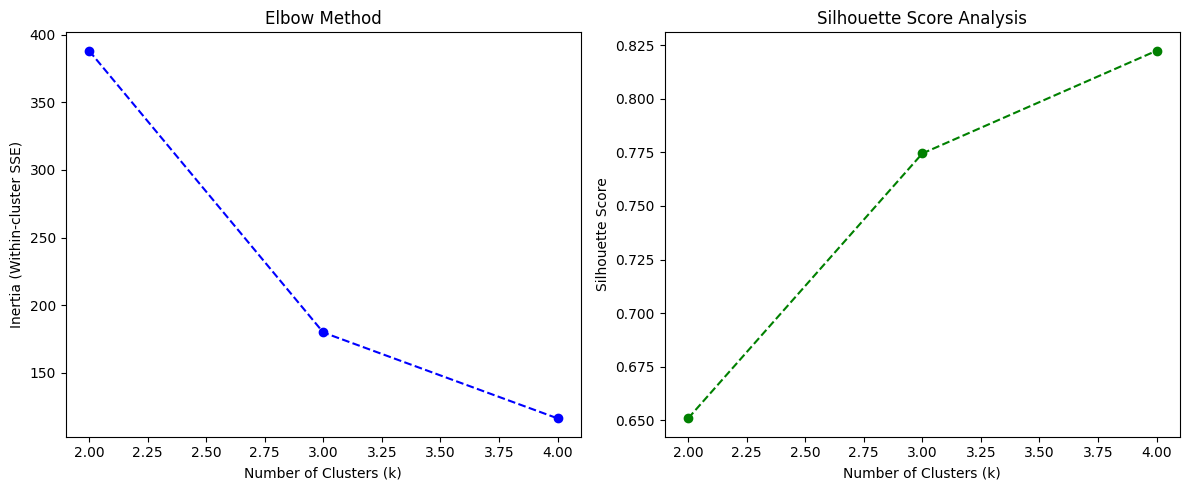

In [85]:
# Elbow Method and Silhouette Score Analysis
inertia = []
silhouette_scores = []
k_values = range(2, 5)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

plt.figure(figsize=(12, 5))

# Elbow Method Plot
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o', linestyle='--', color='b')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-cluster SSE)")
plt.title("Elbow Method")

# Silhouette Score Plot
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--', color='g')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Analysis")

plt.tight_layout()
plt.show()

In [86]:
# Calculate a composite ranking score for each cluster
cluster_means['Ranking Score'] = cluster_means.sum(axis=1)
# Rank clusters based on the composite score in descending order
cluster_ranking = cluster_means[['Ranking Score']].sort_values(by='Ranking Score', ascending=False)
cluster_ranking['Rank'] = range(1, len(cluster_ranking) + 1)
# Save the ranking to an Excel file
cluster_ranking.to_excel('Cluster_Ranking.xlsx', index_label='Cluster')
# Display the ranking
print("Cluster Ranking based on composite score:")
print(cluster_ranking)

Cluster Ranking based on composite score:
         Ranking Score  Rank
Cluster                     
0             3.946970     1
3             3.000000     2
2             2.772727     3
1             1.818182     4
